## Imports

In [1]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

import time
import os

from tempfile import TemporaryDirectory

In [2]:
# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:
# device = torch.device("cpu")

## Load data

In [4]:
class LabeledData(Dataset):
    def __init__(self, annotation_file, transform=None) -> None:
        self._annotations = pd.read_csv(annotation_file)
        self.labels = self._annotations["label"]
        self.images_path = self._annotations["sample"]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(DATA_PATH, self.images_path[idx])
        image = Image.open(_path_to_image).convert("RGB")
        label = self.labels[idx].item()

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)


class UnlabeledData(Dataset):
    def __init__(self) -> None:
        raise NotImplementedError

In [5]:
DATA_PATH = os.path.join(os.getcwd(), "data")

TASK1_PATH = os.path.join(DATA_PATH, "task1")
TRAIN_TASK1 = os.path.join(TASK1_PATH, "train_data","annotations.csv")
VAL_TASK1 = os.path.join(TASK1_PATH, "val_data")

TASK2_PATH = os.path.join(DATA_PATH, "task2")
TRAIN_TASK2 = os.path.join(TASK2_PATH, "train_data","annotations.csv")
VAL_TASK2 = os.path.join(TASK2_PATH, "val_data")

In [6]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)

In [7]:
dataset = LabeledData(TRAIN_TASK1,transform=transform)

In [9]:
def get_split_dataset(
    data,
    seed=42,
    test_size=0.2,
    batch_size = 64
):
    """Taken form https://stackoverflow.com/a/68338670"""
   
    # generate indices: instead of the actual data we pass in integers instead
    train_indices, test_indices, _, _ = train_test_split(
        range(len(data)),
        data.labels,
        stratify=data.labels,
        test_size=test_size,
        random_state=seed,
    )

    # generate subset based on indices
    train_split = Subset(data, train_indices)
    test_split = Subset(data, test_indices)

    # create batches
    train_batches = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    test_batches = DataLoader(test_split, batch_size=batch_size)


    return train_batches, test_batches

In [10]:
train_loader,valid_loader = get_split_dataset(dataset,batch_size=64)

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

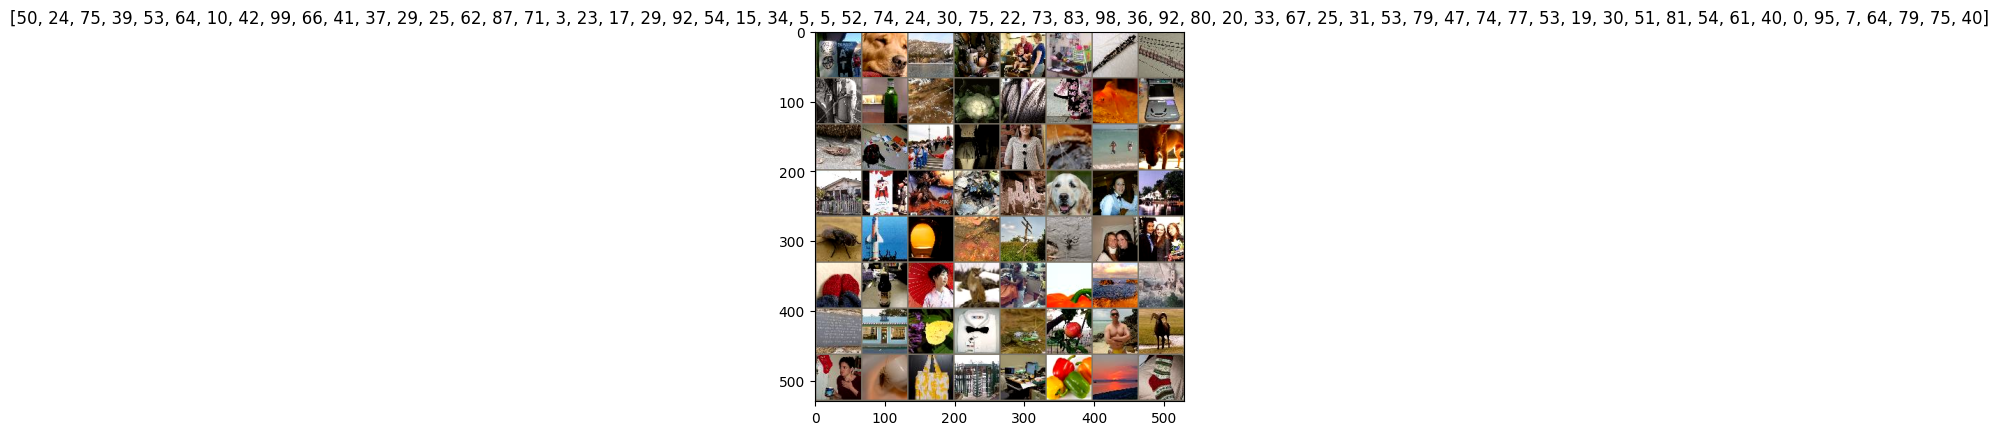

In [11]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

## Base model resnet50

In [66]:
def train_model(model, criterion, optimizer, scheduler,train_loader,valid_loader, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Training phase

            model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = running_corrects.float() / len(train_loader)

            print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            print()

            model.eval()

            running_loss = 0.0
            running_corrects = 0
            # Validation phase
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(valid_loader)
            epoch_acc = running_corrects.float() / len(valid_loader)

            print(f"Valid\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model

In [13]:
model_ft = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 100)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 199.2421 Acc: 22.7492

Valid
	 Loss: 104.7263 Acc: 38.9189
Epoch 1/9
----------
Train
	 Loss: 86.5572 Acc: 42.2983

Valid
	 Loss: 78.7766 Acc: 43.3514
Epoch 2/9
----------
Train
	 Loss: 58.7562 Acc: 48.5695

Valid
	 Loss: 73.0621 Acc: 44.5405
Epoch 3/9
----------
Train
	 Loss: 41.9784 Acc: 52.7797

Valid
	 Loss: 69.9869 Acc: 45.1216
Epoch 4/9
----------
Train
	 Loss: 30.4124 Acc: 56.1763

Valid
	 Loss: 70.7140 Acc: 45.1622
Epoch 5/9
----------
Train
	 Loss: 22.0923 Acc: 58.3593

Valid
	 Loss: 70.7275 Acc: 45.4459
Epoch 6/9
----------
Train
	 Loss: 16.4268 Acc: 59.8915

Valid
	 Loss: 71.4717 Acc: 45.4595
Epoch 7/9
----------
Train
	 Loss: 12.0290 Acc: 61.3424

Valid
	 Loss: 70.6019 Acc: 45.8108
Epoch 8/9
----------
Train
	 Loss: 11.4459 Acc: 61.5661

Valid
	 Loss: 71.9450 Acc: 45.3649
Epoch 9/9
----------
Train
	 Loss: 10.6905 Acc: 61.7051

Valid
	 Loss: 71.5956 Acc: 45.4189
Training complete in 18m 9s
Best val Acc: 45.810810


In [42]:
import re
from tqdm import tqdm


def natural_sort_key(s):
    return [
        int(text) if text.isdigit() else text.lower() for text in re.split(r"(\d+)", s)
    ]


def predict(model, transform, img_path, base_dir=""):
    img = Image.open(os.path.join(base_dir, img_path)).convert("RGB")
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    return preds[0].item()


def create_submission(model, transform=None, valid_dir: str = None):
    if valid_dir is None:
        raise TypeError("The path must be str")

    image_paths = sorted(os.listdir(valid_dir), key=natural_sort_key)

    valid_dict = {}
    for img_path in tqdm(image_paths, desc="Predict images"):
        valid_dict[img_path] = predict(model, transform, img_path, valid_dir)

    return valid_dict

In [43]:
dict_to_submit = create_submission(model_ft,transform,VAL_TASK1)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:33<00:00, 53.49it/s]


In [45]:
dict_to_submit

{'0.jpeg': 0,
 '1.jpeg': 6,
 '2.jpeg': 67,
 '3.jpeg': 82,
 '4.jpeg': 47,
 '5.jpeg': 27,
 '6.jpeg': 22,
 '7.jpeg': 65,
 '8.jpeg': 4,
 '9.jpeg': 53,
 '10.jpeg': 35,
 '11.jpeg': 71,
 '12.jpeg': 78,
 '13.jpeg': 33,
 '14.jpeg': 28,
 '15.jpeg': 6,
 '16.jpeg': 80,
 '17.jpeg': 50,
 '18.jpeg': 32,
 '19.jpeg': 55,
 '20.jpeg': 65,
 '21.jpeg': 14,
 '22.jpeg': 61,
 '23.jpeg': 31,
 '24.jpeg': 79,
 '25.jpeg': 71,
 '26.jpeg': 57,
 '27.jpeg': 88,
 '28.jpeg': 82,
 '29.jpeg': 89,
 '30.jpeg': 55,
 '31.jpeg': 51,
 '32.jpeg': 28,
 '33.jpeg': 62,
 '34.jpeg': 47,
 '35.jpeg': 0,
 '36.jpeg': 83,
 '37.jpeg': 63,
 '38.jpeg': 58,
 '39.jpeg': 26,
 '40.jpeg': 18,
 '41.jpeg': 40,
 '42.jpeg': 5,
 '43.jpeg': 86,
 '44.jpeg': 79,
 '45.jpeg': 33,
 '46.jpeg': 34,
 '47.jpeg': 49,
 '48.jpeg': 63,
 '49.jpeg': 51,
 '50.jpeg': 15,
 '51.jpeg': 93,
 '52.jpeg': 46,
 '53.jpeg': 44,
 '54.jpeg': 18,
 '55.jpeg': 22,
 '56.jpeg': 53,
 '57.jpeg': 10,
 '58.jpeg': 66,
 '59.jpeg': 99,
 '60.jpeg': 11,
 '61.jpeg': 51,
 '62.jpeg': 29,
 '63.jpe

In [54]:
df = pd.DataFrame.from_dict(dict_to_submit, orient="index")
df.reset_index(inplace=True)
df

,index,0
0,0.jpeg,0
1,1.jpeg,6
2,2.jpeg,67
3,3.jpeg,82
4,4.jpeg,47
...,...,...
4995,4995.jpeg,34
4996,4996.jpeg,22
4997,4997.jpeg,2
4998,4998.jpeg,38


In [57]:
df.columns = ["sample", "label"]

In [59]:
df.to_csv("fist.csv",index=False)

### Task2

In [ ]:
def write_submission(data: pd.DataFrame, filename: str = None, task: str = None):
    submission_dir = os.path.join(DATA_PATH, "submission")

    if not submission_dir.exists():
        os.mkdir(submission_dir)

    _filename = os.path.join(DATA_PATH, submission_dir, filename + ".csv")

    index = 0
    while not os.path.exists(_filename):
        _filename = os.path.join(
            DATA_PATH, submission_dir, filename + str(index) + ".csv"
        )
        index = index + 1
    
    data.to_csv(_filename,index=False)

In [61]:
dataset_task2 = LabeledData(TRAIN_TASK2, transform=transform)

In [64]:
dataset_task2.labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [62]:
train_loader_task2, valid_loader_task2 = get_split_dataset(dataset_task2, batch_size=64)

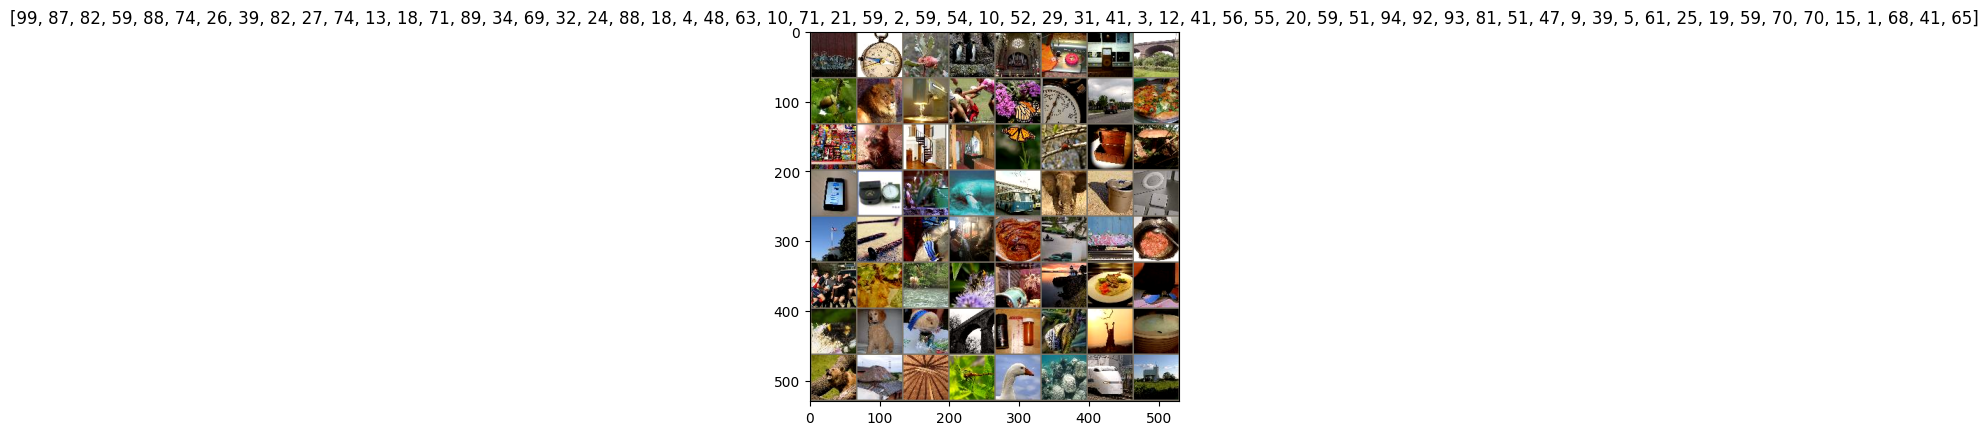

In [63]:
# Get a batch of training data
inputs, classes = next(iter(train_loader_task2))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

In [67]:
model_task2 = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_task2.fc = nn.Linear(num_ftrs, 100)

model_task2 = model_task2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_task2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [68]:
model_task2 = train_model(
    model_task2, criterion, optimizer_ft, exp_lr_scheduler, train_loader_task2,valid_loader_task2,num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 168.6279 Acc: 25.4112

Valid
	 Loss: 105.0127 Acc: 35.5732
Epoch 1/9
----------
Train
	 Loss: 93.1180 Acc: 37.9216

Valid
	 Loss: 94.0869 Acc: 37.2484
Epoch 2/9
----------
Train
	 Loss: 72.6184 Acc: 42.3856

Valid
	 Loss: 89.4801 Acc: 38.0064
Epoch 3/9
----------
Train
	 Loss: 58.8802 Acc: 45.7920

Valid
	 Loss: 89.0262 Acc: 38.1656
Epoch 4/9
----------
Train
	 Loss: 47.3953 Acc: 48.8528

Valid
	 Loss: 90.3746 Acc: 38.0064
Epoch 5/9
----------
